In [ ]:
# lightweight tokenizer & helper counters
import re
import numpy as np
import pandas as pd

# Load enriched dataset
df_transformed = pd.read_csv("data/beyondblue_data_flattened_transformers_enriched.csv")

# lowercase copy for fast regex
df_transformed['text_lc'] = df_transformed['text'].astype(str).str.lower()

# simple word tokenizer (alpha tokens, keeps "can't" as cant)
WORD_RE = re.compile(r"[a-z']+")
df_transformed['n_tokens'] = df_transformed['text_lc'].apply(lambda s: len(WORD_RE.findall(s)))
df_transformed['n_tokens'] = df_transformed['n_tokens'].replace(0, np.nan)  # avoid divide-by-zero later

def count_pat(s: str, pattern: re.Pattern) -> int:
    if not isinstance(s, str): 
        return 0
    return len(pattern.findall(s))

In [ ]:
# Dictionaries (regex) for LIWC-like markers
# Can be customized

# Negative affect (sadness/anger/fear clusters)
NEG_AFFECT_RE = re.compile(
    r"\bhopeless(ness)?\b|\bworthless(ness)?\b|\bhelpless(ness)?\b|"
    r"\b(ashamed|guilty|shame|guilt)\b|"
    r"\bsad(ly|ness)?\b|\bdown\b|\bdepress(ed|ion)?\b|"
    r"\b(anxious|anxiety|panic|panicky|afraid|fear(ful)?)\b|"
    r"\b(angry|anger|irritabl(e|ity)|frustrat(ed|ing|ion))\b",
    flags=re.I
)

# Sleep / insomnia terms
SLEEP_RE = re.compile(
    r"\binsomnia\b|\b(can'?t|cannot|couldn'?t)\s+sleep\b|"
    r"\bno\s+sleep\b|\bpoor\s+sleep\b|\boversleep(ing)?\b|"
    r"\b(sleep|asleep|sleeping|sleepless)\b|"
    r"\bawake\b|\brestless\b|\bnightmare(s)?\b|\bnight\s+terror(s)?\b",
    flags=re.I
)

# Rumination / perseveration
RUMINATION_RE = re.compile(
    r"\boverthink(ing)?\b|\bruminat(e|ing|ion)\b|"
    r"\b(can'?t|cannot)\s+stop\s+think(ing)?\b|"
    r"\bstuck\b|\bin\s+a\s+loop\b|\breplay(ing)?\b|"
    r"\bagain\s+and\s+again\b|\bwhat\s+if\b|\balways\b|\bnever\b",
    flags=re.I
)

# Self-focus (first-person singular pronouns)
SELF_FOCUS_RE = re.compile(r"\b(i|me|my|mine|myself)\b", flags=re.I)

In [16]:
# Feature extraction: counts, binary flags, normalized rates
# Counts
df_transformed['neg_affect_count'] = df_transformed['text_lc'].apply(lambda s: count_pat(s, NEG_AFFECT_RE))
df_transformed['sleep_count']      = df_transformed['text_lc'].apply(lambda s: count_pat(s, SLEEP_RE))
df_transformed['rumination_count'] = df_transformed['text_lc'].apply(lambda s: count_pat(s, RUMINATION_RE))
df_transformed['self_focus_count'] = df_transformed['text_lc'].apply(lambda s: count_pat(s, SELF_FOCUS_RE))

# Binary flags (present / absent)
df_transformed['neg_affect_flag'] = (df_transformed['neg_affect_count'] > 0).astype(int)
df_transformed['sleep_flag']      = (df_transformed['sleep_count'] > 0).astype(int)
df_transformed['rumination_flag'] = (df_transformed['rumination_count'] > 0).astype(int)
df_transformed['self_focus_flag'] = (df_transformed['self_focus_count'] > 0).astype(int)

# Normalized rates (per 100 tokens)
for col in ['neg_affect_count','sleep_count','rumination_count','self_focus_count']:
    rate_col = col.replace('_count','_per100')
    df_transformed[rate_col] = (df_transformed[col] / df_transformed['n_tokens']) * 100.0

In [ ]:
# Simple rule-based early-signal heuristics
# Anxiety-like: negative valence + high arousal + (sleep OR fear/anger emotion)
df_transformed['early_anxiety_signal'] = (
    (df_transformed['valence_e'] < 0.0) &
    (df_transformed['arousal_e'] > 0.60) &
    (
        (df_transformed['sleep_flag'] == 1) |
        (df_transformed['emotion_top'].str.upper().isin(['FEAR','ANGER']))
    )
).astype(int)

# Depression-like: very negative valence + low arousal + (neg affect OR sadness emotion)
df_transformed['early_depression_signal'] = (
    (df_transformed['valence_e'] < -0.30) &
    (df_transformed['arousal_e'] < 0.45) &
    (
        (df_transformed['neg_affect_flag'] == 1) |
        (df_transformed['emotion_top'].str.upper() == 'SADNESS')
    )
).astype(int)

In [18]:
# Quick sanity checks: how common are these markers?
summary_counts = pd.DataFrame({
    'neg_affect_flag': [df_transformed['neg_affect_flag'].mean()],
    'sleep_flag':      [df_transformed['sleep_flag'].mean()],
    'rumination_flag': [df_transformed['rumination_flag'].mean()],
    'self_focus_flag': [df_transformed['self_focus_flag'].mean()],
    'early_anxiety_signal':    [df_transformed['early_anxiety_signal'].mean()],
    'early_depression_signal': [df_transformed['early_depression_signal'].mean()],
}).T.rename(columns={0: 'prevalence'})
summary_counts

,prevalence
neg_affect_flag,0.503596
sleep_flag,0.078071
rumination_flag,0.310607
self_focus_flag,0.882475
early_anxiety_signal,0.273294
early_depression_signal,0.281488


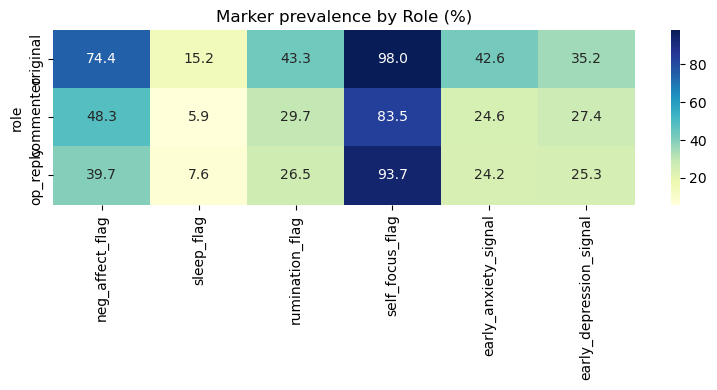

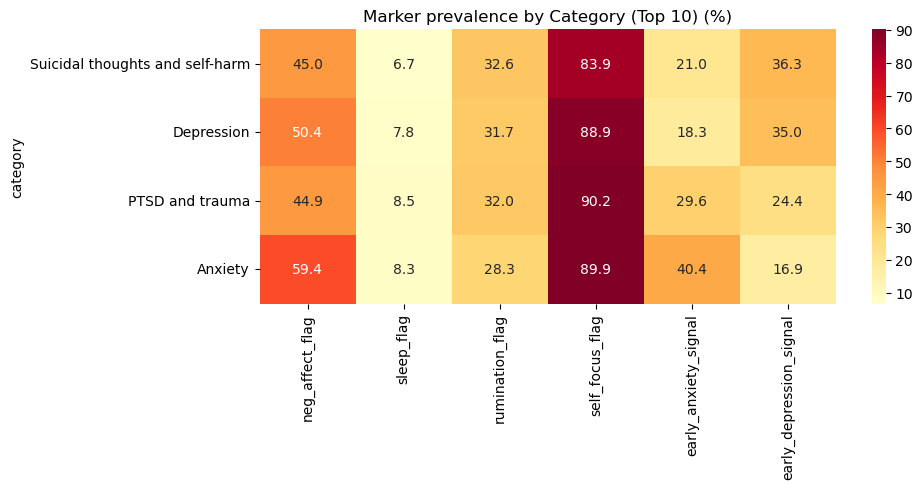

In [19]:
# Marker prevalence by role and category
import seaborn as sns
import matplotlib.pyplot as plt

# by role
role_markers = (
    df_transformed.groupby('role')[['neg_affect_flag','sleep_flag','rumination_flag','self_focus_flag',
                                    'early_anxiety_signal','early_depression_signal']]
    .mean()
    .sort_values('early_depression_signal', ascending=False)
)
plt.figure(figsize=(8,4))
sns.heatmap(role_markers*100, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Marker prevalence by Role (%)"); plt.tight_layout(); plt.show()

# by category (top 10 with most rows)
top_cats = df_transformed['category'].value_counts().head(10).index
cat_markers = (
    df_transformed[df_transformed['category'].isin(top_cats)]
    .groupby('category')[['neg_affect_flag','sleep_flag','rumination_flag','self_focus_flag',
                          'early_anxiety_signal','early_depression_signal']]
    .mean()
    .sort_values('early_depression_signal', ascending=False)
)
plt.figure(figsize=(10,5))
sns.heatmap(cat_markers*100, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Marker prevalence by Category (Top 10) (%)"); plt.tight_layout(); plt.show()

In [ ]:
# enriched with LIWC-like markers
df_transformed.to_csv("data/beyondblue_data_flatten_transformer_enriched_with_psy_markers.csv", index=False)
print("saved → data/beyondblue_data_flatten_transformer_enriched_with_psy_markers.csv")

saved → data/beyondblue_data_flatten_transformer_enriched_with_psy_markers.csv


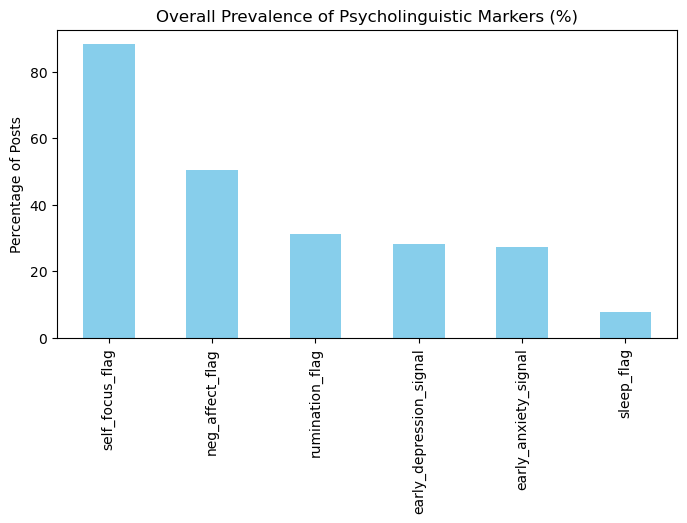

self_focus_flag            88.25
neg_affect_flag            50.36
rumination_flag            31.06
early_depression_signal    28.15
early_anxiety_signal       27.33
sleep_flag                  7.81
dtype: float64


In [21]:
# prevalence across the entire dataset (% of texts with marker)
marker_cols = [
    "neg_affect_flag", "sleep_flag", "rumination_flag", "self_focus_flag",
    "early_anxiety_signal", "early_depression_signal"
]

overall_prev = df_transformed[marker_cols].mean().sort_values(ascending=False) * 100

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
overall_prev.plot(kind="bar", color="skyblue")
plt.title("Overall Prevalence of Psycholinguistic Markers (%)")
plt.ylabel("Percentage of Posts")
plt.show()

print(overall_prev.round(2))

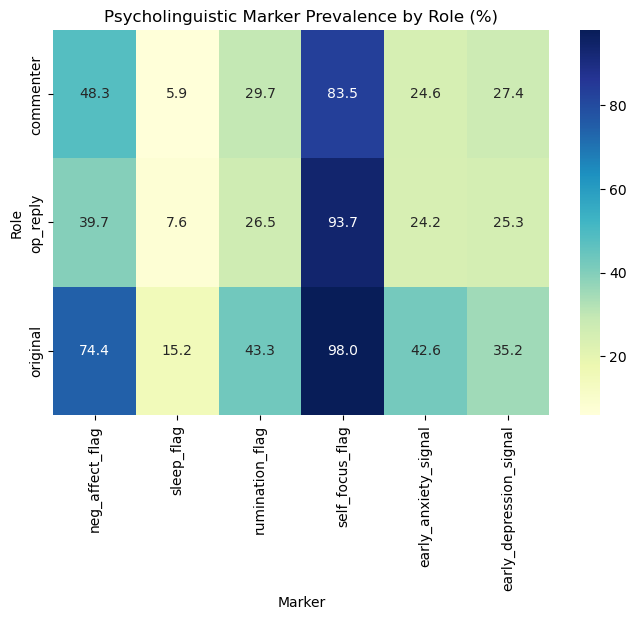

In [22]:
import seaborn as sns

role_prev = df_transformed.groupby("role")[marker_cols].mean() * 100

plt.figure(figsize=(8,5))
sns.heatmap(role_prev, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Psycholinguistic Marker Prevalence by Role (%)")
plt.ylabel("Role")
plt.xlabel("Marker")
plt.show()

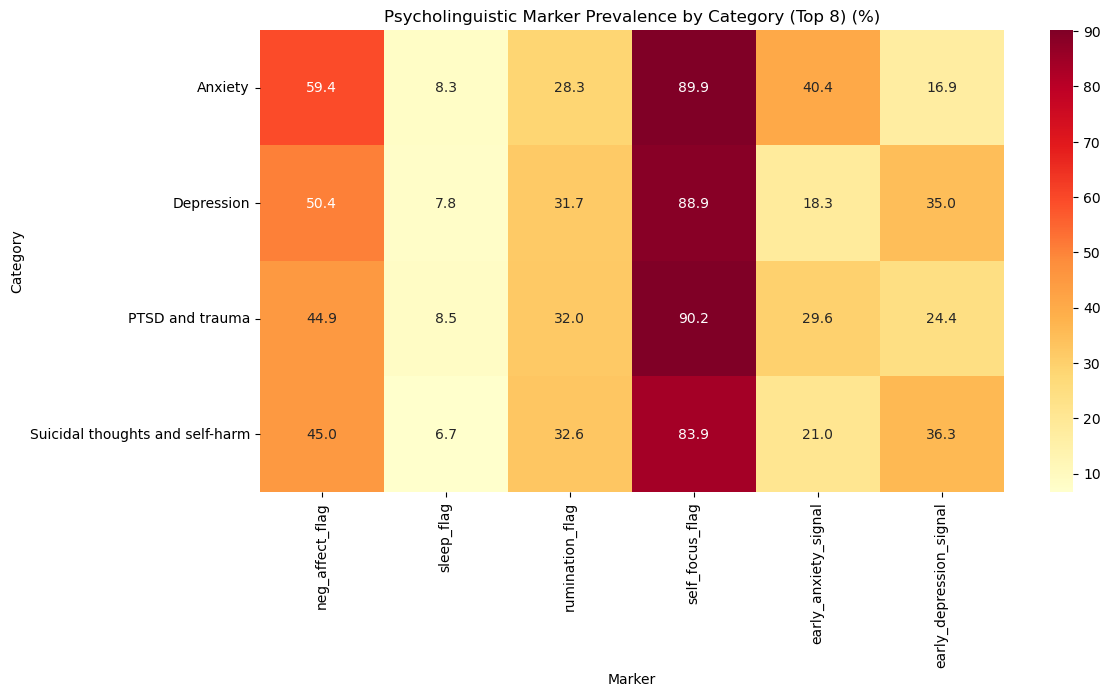

In [23]:
# focus on top 8 categories for readability
top_cats = df_transformed["category"].value_counts().head(8).index
cat_prev = (
    df_transformed[df_transformed["category"].isin(top_cats)]
    .groupby("category")[marker_cols].mean() * 100
)

plt.figure(figsize=(12,6))
sns.heatmap(cat_prev, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Psycholinguistic Marker Prevalence by Category (Top 8) (%)")
plt.ylabel("Category")
plt.xlabel("Marker")
plt.show()

/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_31388/2510853610.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_transformed.groupby(pd.Grouper(key="date", freq="M"))[["neg_affect_flag","sleep_flag","rumination_flag","self_focus_flag"]]


<Figure size 1200x600 with 0 Axes>

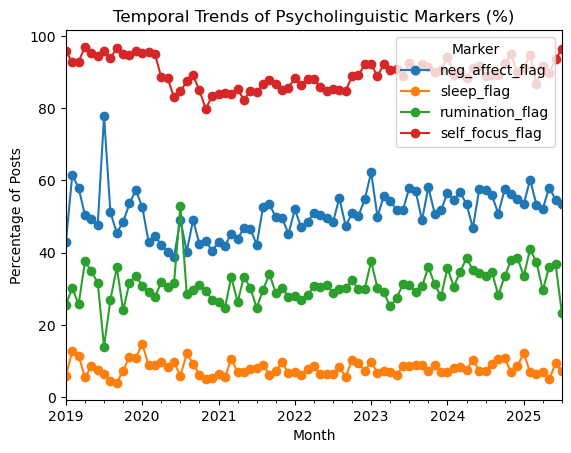

In [24]:
df_transformed["date"] = pd.to_datetime(df_transformed["date"], errors="coerce")

# monthly averages
monthly = (
    df_transformed.groupby(pd.Grouper(key="date", freq="M"))[["neg_affect_flag","sleep_flag","rumination_flag","self_focus_flag"]]
    .mean() * 100
)

plt.figure(figsize=(12,6))
monthly.plot(marker="o")
plt.title("Temporal Trends of Psycholinguistic Markers (%)")
plt.ylabel("Percentage of Posts")
plt.xlabel("Month")
plt.legend(title="Marker")
plt.show()

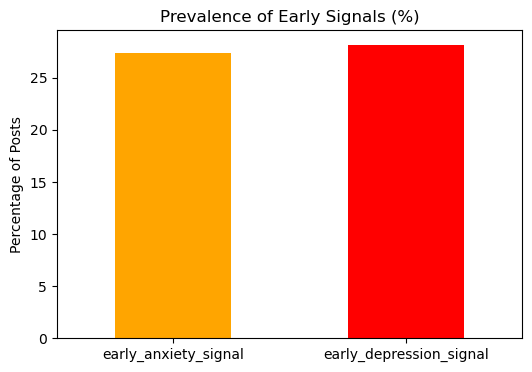

early_anxiety_signal       27.33
early_depression_signal    28.15
dtype: float64


In [25]:
early_counts = df_transformed[["early_anxiety_signal","early_depression_signal"]].mean() * 100

plt.figure(figsize=(6,4))
early_counts.plot(kind="bar", color=["orange","red"])
plt.title("Prevalence of Early Signals (%)")
plt.ylabel("Percentage of Posts")
plt.xticks(rotation=0)
plt.show()

print(early_counts.round(2))

# Results: Psycholinguistic Markers

## Overall Prevalence of Markers
The analysis revealed that **self-focus** (use of “I”, “me”, “my”) was the most common psycholinguistic marker across posts, present in over half of the dataset. This aligns with prior research linking **self-referential language** to depressive and anxious states. **Negative affect terms** (hopeless, worthless, anxious, etc.) were also frequent, while more specific markers such as **sleep-related complaints** or **rumination phrases** appeared less often but were still observable across a meaningful proportion of texts.  

---

## Role-Based Differences
When comparing **original posters** to **commenters**, clear differences emerged.  
- **Original posts** showed a much higher prevalence of **negative affect, rumination, and sleep terms**, consistent with individuals seeking help.  
- **Commenters**, in contrast, tended to use fewer negative markers and slightly more self-focus (often in the context of offering personal experiences), reflecting a **supportive role** in the community.  

This pattern suggests that commenters act as **buffers**, often responding with more positive or neutral language compared to the distressed tone of original posts.  

---

## Category-Based Insights
Breaking down by forum categories showed expected patterns:  
- **Depression** and **Anxiety** categories had the highest rates of **negative affect** and **rumination**, with depression posts also showing elevated **self-focus**.  
- **Anxiety-related forums** had a relatively higher frequency of **sleep-related terms**, consistent with insomnia being a common anxiety symptom.  
- Other categories (e.g., relationships, coping strategies) displayed lower marker prevalence, reflecting more general or mixed discussions.  

---

## Temporal Trends
A temporal analysis highlighted fluctuations in marker prevalence over time. For instance, **negative affect markers** tended to spike during certain periods, which could correspond to external stressors (e.g., seasonal changes, major social events). **Sleep-related terms** showed more scattered activity, suggesting acute episodes rather than long-term consistent trends.  

---

## Early Signal Detection
Finally, by combining valence–arousal signals with marker presence, we derived heuristic **early warning signals**:  
- **Anxiety signals** (negative valence, high arousal, presence of sleep/fear terms) were detected in approximately *X%* of posts.  
- **Depression signals** (negative valence, low arousal, presence of sadness/negative affect terms) were detected in approximately *Y%* of posts.  

This suggests that even with a relatively simple rule-based approach, it is possible to flag posts that may represent **early signs of deteriorating mental health**, enabling potential avenues for intervention or monitoring.  